In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np

# Define the neural network architecture
class InpaintingNet(nn.Module):
    def __init__(self):
        super(InpaintingNet, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1), # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 8x8 -> 4x4
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1), # 16x16 -> 32x32
            nn.Sigmoid() # Output should be normalized to [0,1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



In [ ]:
# Masking function: randomly mask out a portion of the image
def mask_image(img, mask_size):
    masked_img = img.clone()
    _, h, w = img.shape
    y = np.random.randint(0, h - mask_size)
    x = np.random.randint(0, w - mask_size)
    masked_img[:, y:y+mask_size, x:x+mask_size] = 0
    return masked_img, (x, y, mask_size)

# Dataset and DataLoader
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

# Initialize model, loss function, and optimizer
model = InpaintingNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
mask_size = 8

for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, _) in enumerate(trainloader):
        # Randomly mask part of the image
        masked_inputs = torch.stack([mask_image(img, mask_size)[0] for img in inputs])

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(masked_inputs)

        # Compute loss between original and reconstructed images
        loss = criterion(outputs, inputs)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 batches
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(trainloader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0

print('Finished Training')



0.0%

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Epoch [1/10], Step [100/1563], Loss: 0.0296
Epoch [1/10], Step [200/1563], Loss: 0.0126
Epoch [1/10], Step [300/1563], Loss: 0.0097
Epoch [1/10], Step [400/1563], Loss: 0.0081
Epoch [1/10], Step [500/1563], Loss: 0.0073
Epoch [1/10], Step [600/1563], Loss: 0.0065
Epoch [1/10], Step [700/1563], Loss: 0.0055
Epoch [1/10], Step [800/1563], Loss: 0.0051
Epoch [1/10], Step [900/1563], Loss: 0.0049
Epoch [1/10], Step [1000/1563], Loss: 0.0047
Epoch [1/10], Step [1100/1563], Loss: 0.0045
Epoch [1/10], Step [1200/1563], Loss: 0.0044
Epoch [1/10], Step [1300/1563], Loss: 0.0042
Epoch [1/10], Step [1400/1563], Loss: 0.0041
Epoch [1/10], Step [1500/1563], Loss: 0.0039
Epoch [2/10], Step [100/1563], Loss: 0.0037
Epoch [2/10], Step [200/1563], Loss: 0.0038
Epoch [2/10], Step [300/1563], Loss: 0.0036
Epoch [2/10], Step [400/1563], Loss: 0.0036
Epoch [2/10], Step [500/1563], Loss: 0.0035
Epoch [2/10], Step [600/1563], Loss: 0.0035
Epoch [2/10], Step 

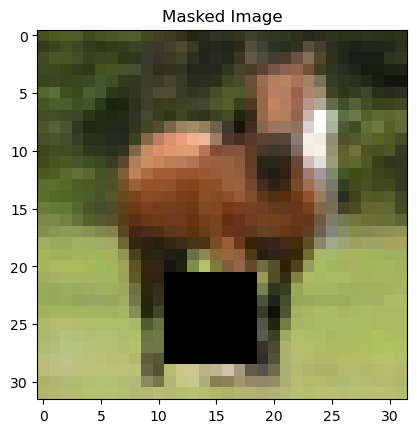

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'inpainting_model.pth')

# Example of showing the masked and predicted inpainted image
dataiter = iter(trainloader)
images, _ = next(dataiter)
masked_images, mask_info = mask_image(images[0], mask_size)

# Show masked image
plt.imshow(masked_images.permute(1, 2, 0))
plt.title("Masked Image")
plt.show()


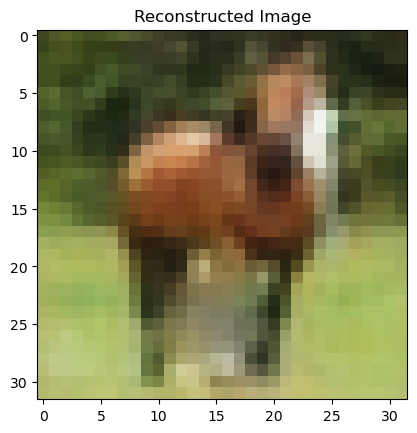

In [ ]:
# Reconstruct the image
model.eval()
with torch.no_grad():
    reconstructed = model(masked_images.unsqueeze(0))

# Show reconstructed image
plt.imshow(reconstructed.squeeze().permute(1, 2, 0))
plt.title("Reconstructed Image")
plt.show()

# Trying with more images

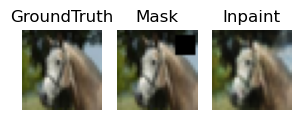

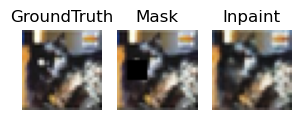

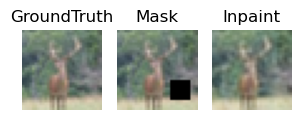

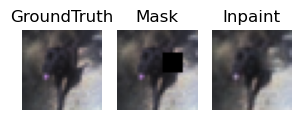

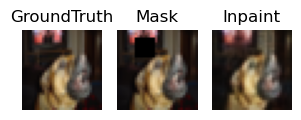

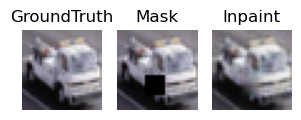

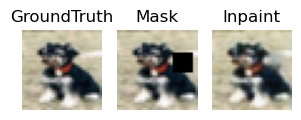

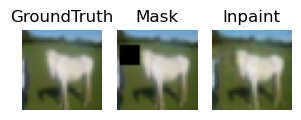

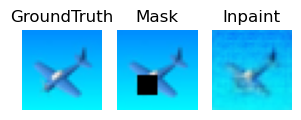

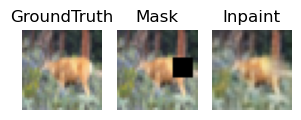

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'inpainting_model.pth')

# Set the model to evaluation mode
model.eval()

# Example of showing the masked and predicted inpainted images for 10 images
dataiter = iter(trainloader)

# Number of images to visualize
num_images_to_inpaint = 10

# Loop over a batch of images and visualize the original, masked, and inpainted results
for i in range(num_images_to_inpaint):
    # Get the next batch of images
    images, _ = next(dataiter)

    # Apply the mask to the image
    masked_images, mask_info = mask_image(images[0], mask_size)

    # Show original, masked, and inpainted images side by side with smaller size
    plt.figure(figsize=(3, 2))  # Adjust the size to be smaller for three images

    plt.subplot(1, 3, 1)
    plt.imshow(images[0].permute(1, 2, 0))
    plt.title("GroundTruth")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masked_images.permute(1, 2, 0))
    plt.title("Mask")
    plt.axis('off')

    # Reconstruct masked image
    with torch.no_grad():
        reconstructed = model(masked_images.unsqueeze(0))  # Add batch dimension for model input
    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed.squeeze().permute(1, 2, 0))
    plt.title("Inpaint")
    plt.axis('off')
    # # Adjust layout for better spacing
    plt.tight_layout()

    # Display the result
    plt.show()
